<a href="https://colab.research.google.com/github/DestonSJU/GenAI/blob/main/HW5/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

//*** Deston Willis

//*** Generative AI

//*** 11/23/24

//*** Homework 5: The purpose of this assignment is to create and train LSTM models and analyze the text that they generate

1. First I set up the data by taking the text from the 3 urls and putting them into 3 text files. I do this so that I can clean the data by removing some unnecessary text and then combining the clean text into one text file. I then preprocess the data so that it can be trained on. For my training data I decide to use 3 text from Mary Shelley: Frankenstein, The Last Man, and The Fortunes of Perkin Warbeck: a Romance.

In [ ]:
#Initial Imports
import numpy as np
import json
import re
import string

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses

In [ ]:
#Initialize variables
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS = 128
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 128
EPOCHS = 50

In [ ]:
import requests

# List of URLs for additional texts (e.g., different Shakespeare plays)
urls = [
          "https://www.gutenberg.org/cache/epub/84/pg84.txt",  # Frankenstein
          "https://www.gutenberg.org/cache/epub/18247/pg18247.txt",   # The Last Man
          "https://www.gutenberg.org/cache/epub/66749/pg66749.txt"   # The Fortunes of Perkin Warbeck: a Romance
      ]

# Initialize an empty string to hold the text
all_text = ""

# Download the text file and append to all_text
response = requests.get(urls[0])
text = response.text
all_text += text + "\n\n"  # Separate texts by newlines

# Save 1st text to a file
with open("shelley1.txt", "w", encoding="utf-8") as file:
    file.write(all_text)

In [ ]:
# Clean 1st text
shelley_text1 = open("shelley1.txt").readlines()
shelley_text1 = shelley_text1[66:7386]

In [ ]:
# Initialize an empty string to hold the text
all_text = ""

# Download the text file and append to all_text
response = requests.get(urls[1])
text = response.text
all_text += text + "\n\n"  # Separate texts by newlines

# Save 2nd text to a file
with open("shelley2.txt", "w", encoding="utf-8") as file:
    file.write(all_text)

In [ ]:
# Clean 2nd text
shelley_text2 = open("shelley2.txt").readlines()
shelley_text2 = shelley_text2[77:16570]

In [ ]:
# Initialize an empty string to hold the text
all_text = ""

# Download the text file and append to all_text
response = requests.get(urls[2])
text = response.text
all_text += text + "\n\n"  # Separate texts by newlines

# Save 3rd text to a file
with open("shelley3.txt", "w", encoding="utf-8") as file:
    file.write(all_text)

In [ ]:
# Clean 3rd text
shelley_text3 = open("shelley3.txt").readlines()
shelley_text3 = shelley_text3[188:18007]

In [ ]:
# Combine all texts and write them to a file
all_text = shelley_text1 + shelley_text2 + shelley_text3
with open("combined_shelley.txt", "w", encoding="utf-8") as file:
    file.writelines(all_text)

In [ ]:
# Put text into a variable
shelley_text = open("combined_shelley.txt").readlines()

In [ ]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


text_data = [pad_punctuation(x) for x in shelley_text]

In [ ]:
# Display an example of a recipe
example_data = text_data[2]
example_data

' _ To Mrs . Saville , England . _ \n'

In [ ]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [ ]:
# Create a vectorisation layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [ ]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [ ]:
# Display some token:word mappings
for i, word in enumerate(vocab[:10]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: ,
3: the
4: of
5: .
6: and
7: to
8: ;
9: a


In [ ]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())

[ 261    7 7287    5 7085    2  116    5  261    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
# Create the training set of recipes and the same text shifted by one word
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_ds = text_ds.map(prepare_inputs)

2. Next I create the LSTM model. It has an input layer, an embedding layer, a lstm layer with 128 units, and a dense layer. I then set up a text generator class and train the model for 50 epochs. When training the model, I use "the" as the prompt for the text generated during training. The model loss is 0.2181 and the generated text is "The a sense of patriotic peril . for the time he had brought an ". This text doesn't make much sense coherently, but stylistic slightly matches the training text with the use of "peril".

In [ ]:
# Create model with one lstm layer with 128 units
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 100)           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 128)           │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 10000)         │       1,290,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,407,248 (9.18 MB)

 Trainable params: 2,407,248 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Loss function
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

In [ ]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }  # <1>

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]  # <3>
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:  # <4>
            x = np.array([start_tokens])
            y = self.model.predict(x, verbose=0)  # <5>
            sample_token, probs = self.sample_from(y[0][-1], temperature)  # <6>
            info.append({"prompt": start_prompt, "word_probs": probs})
            start_tokens.append(sample_token)  # <7>
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("The", max_tokens=25, temperature=1.0)

In [ ]:
# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [ ]:
# Train model for 50 epochs
lstm.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[text_generator],
)

Epoch 1/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.3182
generated text:
The as the preserved of distress , 

326/326 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - loss: 2.3140
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.3769
generated text:
The [UNK] [UNK] auguries were had ensure and had 

326/326 ━━━━━━━━━━━━━━━━━━━━ 48s 146ms/step - loss: 0.3769
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.3544
generated text:
The - created , know the trees , and earth her 

326/326 ━━━━━━━━━━━━━━━━━━━━ 48s 146ms/step - loss: 0.3544
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.3384
generated text:
The , if william was degrees in the whole perseverance , to perceive her 

326/326 ━━━━━━━━━━━━━━━━━━━━ 48s 146ms/step - loss: 0.3384
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.3247
generated text:
The of [UNK] . his first tranquillity from it , might not an [UNK] 

326/326 ━━━━━━━━━━━━━━━━━━━━ 48s 148ms/step - loss: 0.3247

3. I first adjust the model by training two more models with 2 and 3 lstm layer respectively. The loss for the model with 2 lstm layers is 0.1980 and the generated text is "The girl , " will thus you be opposed against yourself , or your dog , ". The loss for the model with 3 lstm layers is 0.2099 and the generated text is "The to being the watery end that spoke her ; all sprung from the ". The amount of layers doesn't seem to consistently move the loss up or down as the loss moved up and down as more lstm layers are added. When comparing the texts generated by the 3 models, they don't seem much different from one another in terms of quality. All 3 texts aren't very coherent or make much sense, and they all don't resemble the training data that much, with the first and third model's text having slight hints of it. Next I adjust the model by changing the number of units in the lstm layer. I train two more models: one with 64 units and one with 256. The model with 64 units has a loss of 0.2488 and the generated text is "The and [UNK] a earth , in the leaves of my sentiment , which , no ". The model with 256 units has a loss of 0.1687 and the generated text is "The of who now work would vanish above her , but merely altering the ". Comparing the 3 models, it seems that increasing the units in the lstm layer helps the model to perform better. The loss of the model decreased the more units the lstm layer had and the generated text seems more coherent. While the model with 256 units certainly isn't perfect, its text looks significantly better than the model with 64 units, as that one has an unknown in the text and is incoherent with lots of weird punctuation. However none of the text do too well stylisticly, with the model with 128 units have a slight resembelence of the training data.

In [ ]:
# Create model with 2 lstm layers with 128 units
N_UNITS = 128
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 100)           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 128)           │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 10000)         │       1,290,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,538,832 (9.68 MB)

 Trainable params: 2,538,832 (9.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

lstm.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[text_generator],
)

Epoch 1/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2.3113
generated text:
The growing mine might had you one is be copses ” of 

326/326 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - loss: 2.3071
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.3765
generated text:
The activity narrative the be each meditate . . , my in which father’s 

326/326 ━━━━━━━━━━━━━━━━━━━━ 80s 156ms/step - loss: 0.3765
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.3628
generated text:
The - [UNK] with the restless of the compared was them , with magistrate 

326/326 ━━━━━━━━━━━━━━━━━━━━ 52s 159ms/step - loss: 0.3628
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.3413
generated text:
The ' the knell of near 

326/326 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - loss: 0.3413
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.3266
generated text:
The but ” 

326/326 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - loss: 0.3266
Epoch 6/50
326/326 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Create model with 3 lstm layers with 128 units
N_UNITS = 128
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 100)           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, None, 128)           │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, None, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, None, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 10000)         │       1,290,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,670,416 (10.19 MB)

 Trainable params: 2,670,416 (10.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

lstm.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[text_generator],
)

Epoch 1/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 2.3520
generated text:
The “that disclosed excuse his mourner richard and there : been into 

326/326 ━━━━━━━━━━━━━━━━━━━━ 58s 169ms/step - loss: 2.3478
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.3743
generated text:
The listening had of we in interested father . shelter replied weariness by 

326/326 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - loss: 0.3742
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.3646
generated text:
The but no , the if i nothing the envied ' his [UNK] 

326/326 ━━━━━━━━━━━━━━━━━━━━ 57s 175ms/step - loss: 0.3646
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.3540
generated text:
The abettors and no his s host , a affection the - kindness and 

326/326 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - loss: 0.3540
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.3405
generated text:
The . took you [UNK] by the recollection that there has lost he 

326

In [ ]:
# Create model with one lstm layer with 64 units
N_UNITS = 64
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 100)           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 64)            │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 10000)         │         650,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,692,240 (6.46 MB)

 Trainable params: 1,692,240 (6.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

lstm.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[text_generator],
)

Epoch 1/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 3.2910
generated text:
The first as ; with 

326/326 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - loss: 3.2852
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.3903
generated text:
The their 

326/326 ━━━━━━━━━━━━━━━━━━━━ 38s 115ms/step - loss: 0.3903
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.3679
generated text:
The she him , his swallow sir to peasantry , ! i inhabit richard for vipers and 

326/326 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - loss: 0.3679
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.3499
generated text:
The as had little adding poor [UNK] , solemnity gave intense 

326/326 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - loss: 0.3499
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.3353
generated text:
The . the to forces ; 

326/326 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - loss: 0.3352
Epoch 6/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.3270
generate

In [ ]:
# Create model with one lstm layer with 256 units
N_UNITS = 256
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, None, 100)           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, None, 256)           │         365,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, None, 10000)         │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,935,568 (15.01 MB)

 Trainable params: 3,935,568 (15.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile("adam", loss_fn)

# Tokenize starting prompt

text_generator = TextGenerator(vocab)

lstm.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[text_generator],
)

Epoch 1/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 1.6385
generated text:
The dear stamboul upon fatiguing forgot 

326/326 ━━━━━━━━━━━━━━━━━━━━ 79s 239ms/step - loss: 1.6356
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.3774
generated text:
The wished , your looked ) . as his desolation two ; 

326/326 ━━━━━━━━━━━━━━━━━━━━ 78s 240ms/step - loss: 0.3774
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.3553
generated text:
The perceived , , at it event on vision troops exchanged s renewed ; i done 

326/326 ━━━━━━━━━━━━━━━━━━━━ 79s 242ms/step - loss: 0.3553
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.3383
generated text:
The to action , it , thus to s act . when his huntley to the forked comes our 

326/326 ━━━━━━━━━━━━━━━━━━━━ 79s 243ms/step - loss: 0.3383
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.3222
generated text:
The influence , and every he remained ; during into her 

326/326 ━━━━━━━━━━━━━━━━━━

4. Next I generate text with different prompts and temperatures. I used the model with 1 lstm layer with 256 units to generate these text. I generate text with 3 different prompts and generate 3 texts with each prompt with temperatures of 1, 0.5 and 0.1 respectively. For each generated text, I also display the probablities of what the next word is. The generated texts are in the table below. Starting with the different prompts, it seemed to handle the 2nd prompt (Sorrow only increased with knowledge) the best, while not handling the 1st prompt (All joy was but a mockery) and 3rd prompt (Make me happy) very well. The text from the first prompt made very little sense and had the most unknowns in it. The text from the 3rd prompt wasn't much better than the 1st but not by much and still didn't make much sense. The text from the 2nd prompt wasn't great but some of them at least made a litte bit of sense. I'd say for the most part, none of the prompts produced good sentences stylistically, with there only being very slight instances of replicating the training data. Looking at different temperatures, the main diffrerence I see is that a temperature of 0.1 tended to produce text with more unknowns in it, which wasn't present as much with temperatures of 0.5 and 1. Other than that, the temperature didn't seem to make the generated text better or worse in any meaningful way and for the most part felt similar to each other, though the text wasn't very good.

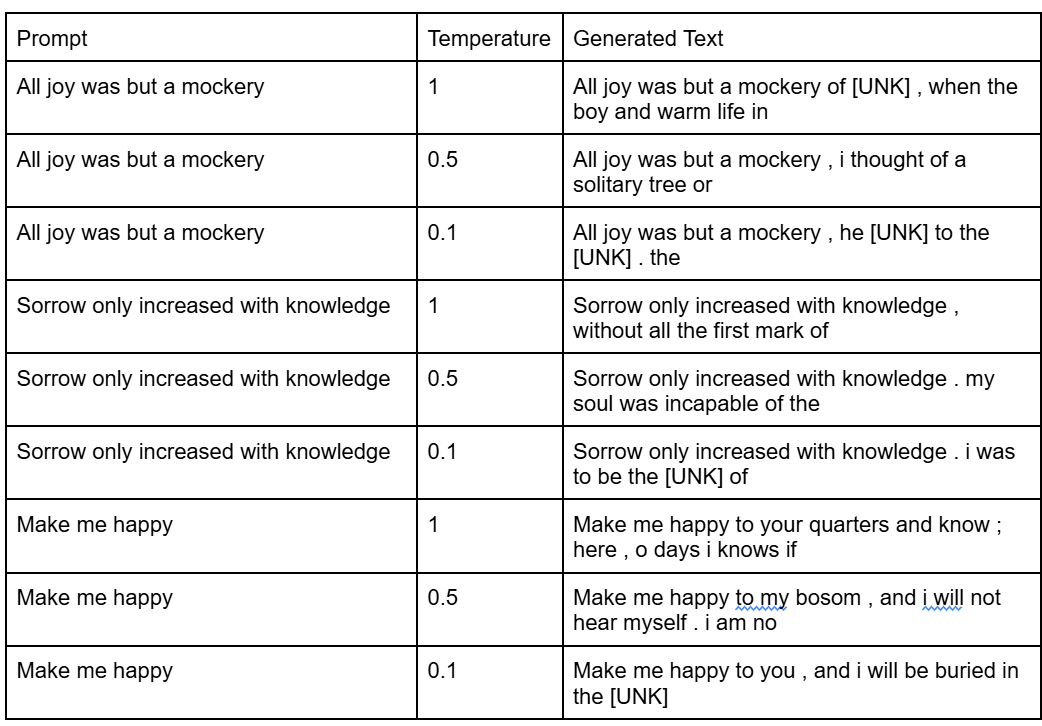

In [ ]:
# Function that prints probablities of next word
def print_probs(info, vocab, top_k=5):
    for i in info:
        print(f"\nPROMPT: {i['prompt']}")
        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [ ]:
# Generate text with temperature of 1
info = text_generator.generate(
    "All joy was but a mockery", max_tokens=25, temperature=1.0
)


generated text:
All joy was but a mockery of [UNK] , when the boy and warm life in 



In [ ]:
# Print probabilites of next word
print_probs(info, vocab)


PROMPT: All joy was but a mockery
of:   	25.74%
,:   	20.82%
.:   	10.72%
to:   	7.99%
;:   	7.84%
--------


PROMPT: All joy was but a mockery of
a:   	17.15%
the:   	8.11%
[UNK]:   	7.74%
his:   	7.1%
an:   	3.15%
--------


PROMPT: All joy was but a mockery of [UNK]
,:   	35.54%
.:   	26.28%
;:   	9.58%
to:   	3.38%
(:   	2.25%
--------


PROMPT: All joy was but a mockery of [UNK] ,
to:   	9.46%
which:   	7.04%
when:   	5.94%
he:   	5.39%
[UNK]:   	4.52%
--------


PROMPT: All joy was but a mockery of [UNK] , when
the:   	19.05%
he:   	12.81%
suddenly:   	6.29%
i:   	6.19%
it:   	4.64%
--------


PROMPT: All joy was but a mockery of [UNK] , when the
[UNK]:   	14.95%
prince:   	2.64%
last:   	1.99%
children:   	1.84%
sun:   	1.75%
--------


PROMPT: All joy was but a mockery of [UNK] , when the boy
dashed:   	10.16%
sang:   	8.67%
had:   	6.8%
was:   	6.76%
went:   	6.06%
--------


PROMPT: All joy was but a mockery of [UNK] , when the boy and
the:   	13.79%
[UNK]:   	6.46%
her:   	

In [ ]:
# Generate text with temperature of 0.5
info = text_generator.generate(
    "All joy was but a mockery", max_tokens=25, temperature=0.5
)


generated text:
All joy was but a mockery , i thought of a solitary tree or 



In [ ]:
# Print probabilites of next word
print_probs(info, vocab)


PROMPT: All joy was but a mockery
of:   	47.46%
,:   	31.05%
.:   	8.24%
to:   	4.57%
;:   	4.41%
--------


PROMPT: All joy was but a mockery ,
he:   	31.08%
that:   	14.04%
i:   	11.9%
a:   	10.23%
to:   	8.89%
--------


PROMPT: All joy was but a mockery , i
saw:   	41.51%
could:   	11.16%
thought:   	10.75%
[UNK]:   	5.06%
had:   	4.97%
--------


PROMPT: All joy was but a mockery , i thought
of:   	46.74%
,:   	24.01%
that:   	19.94%
i:   	1.5%
was:   	1.37%
--------


PROMPT: All joy was but a mockery , i thought of
the:   	56.96%
a:   	18.49%
my:   	11.58%
her:   	8.87%
what:   	3.04%
--------


PROMPT: All joy was but a mockery , i thought of a
[UNK]:   	65.25%
blind:   	6.59%
moment:   	3.66%
man:   	3.66%
miserable:   	3.54%
--------


PROMPT: All joy was but a mockery , i thought of a solitary
tree:   	86.08%
thirst:   	1.5%
manner:   	1.3%
rock:   	1.16%
scene:   	1.09%
--------


PROMPT: All joy was but a mockery , i thought of a solitary tree
.:   	44.87%
,:   	31.77%
wh

In [ ]:
# Generate text with temperature of 0.1
info = text_generator.generate(
    "All joy was but a mockery", max_tokens=25, temperature=0.1
)


generated text:
All joy was but a mockery , he [UNK] to the [UNK] . the 



In [ ]:
# Print probabilites of next word
print_probs(info, vocab)


PROMPT: All joy was but a mockery
of:   	89.28%
,:   	10.7%
.:   	0.01%
to:   	0.0%
;:   	0.0%
--------


PROMPT: All joy was but a mockery ,
he:   	96.79%
that:   	1.82%
i:   	0.8%
a:   	0.37%
to:   	0.19%
--------


PROMPT: All joy was but a mockery , he
had:   	96.4%
[UNK]:   	3.23%
would:   	0.34%
rose:   	0.02%
was:   	0.02%
--------


PROMPT: All joy was but a mockery , he [UNK]
to:   	99.07%
a:   	0.8%
in:   	0.1%
his:   	0.01%
himself:   	0.01%
--------


PROMPT: All joy was but a mockery , he [UNK] to
the:   	99.98%
[UNK]:   	0.02%
his:   	0.0%
her:   	0.0%
himself:   	0.0%
--------


PROMPT: All joy was but a mockery , he [UNK] to the
[UNK]:   	98.85%
throne:   	0.71%
last:   	0.39%
old:   	0.05%
sound:   	0.0%
--------


PROMPT: All joy was but a mockery , he [UNK] to the [UNK]
.:   	99.83%
of:   	0.17%
,:   	0.0%
;:   	0.0%
-:   	0.0%
--------


PROMPT: All joy was but a mockery , he [UNK] to the [UNK] .
the:   	100.0%
he:   	0.0%
it:   	0.0%
his:   	0.0%
in:   	0.0%
-----

In [ ]:
# Generate text with temperature of 1
info = text_generator.generate(
    "Sorrow only increased with knowledge", max_tokens=25, temperature=1.0
)


generated text:
Sorrow only increased with knowledge , without all the first mark of 



In [ ]:
# Print probabilites of next word
print_probs(info, vocab)


PROMPT: Sorrow only increased with knowledge
.:   	44.93%
,:   	18.45%
;:   	9.35%
which:   	8.69%
and:   	8.17%
--------


PROMPT: Sorrow only increased with knowledge ,
nor:   	9.69%
and:   	8.96%
which:   	8.16%
to:   	6.13%
i:   	5.0%
--------


PROMPT: Sorrow only increased with knowledge , without
which:   	13.71%
either:   	4.84%
whom:   	4.63%
to:   	4.59%
the:   	3.43%
--------


PROMPT: Sorrow only increased with knowledge , without all
the:   	33.34%
that:   	5.44%
hope:   	4.8%
those:   	3.23%
a:   	3.02%
--------


PROMPT: Sorrow only increased with knowledge , without all the
[UNK]:   	5.49%
various:   	4.45%
welfare:   	4.09%
result:   	3.54%
influence:   	3.31%
--------


PROMPT: Sorrow only increased with knowledge , without all the first
of:   	15.84%
result:   	12.53%
i:   	3.6%
[UNK]:   	3.11%
sacrifice:   	2.72%
--------


PROMPT: Sorrow only increased with knowledge , without all the first mark
of:   	92.2%
,:   	3.12%
to:   	1.52%
:   	0.59%
i:   	0.59%
--------

In [ ]:
# Generate text with temperature of 0.5
info = text_generator.generate(
    "Sorrow only increased with knowledge", max_tokens=25, temperature=0.5
)


generated text:
Sorrow only increased with knowledge . my soul was incapable of the 



In [ ]:
# Print probabilites of next word
print_probs(info, vocab)


PROMPT: Sorrow only increased with knowledge
.:   	77.7%
,:   	13.1%
;:   	3.37%
which:   	2.91%
and:   	2.57%
--------


PROMPT: Sorrow only increased with knowledge .
i:   	48.33%
:   	24.73%
the:   	8.97%
we:   	4.43%
at:   	2.98%
--------


PROMPT: Sorrow only increased with knowledge . my
father’s:   	48.66%
heart:   	11.54%
mind:   	5.71%
skin:   	4.6%
restoration:   	3.66%
--------


PROMPT: Sorrow only increased with knowledge . my soul
was:   	91.48%
is:   	4.86%
,:   	0.63%
had:   	0.63%
beat:   	0.48%
--------


PROMPT: Sorrow only increased with knowledge . my soul was
to:   	13.05%
on:   	11.31%
a:   	11.01%
not:   	9.39%
[UNK]:   	6.41%
--------


PROMPT: Sorrow only increased with knowledge . my soul was incapable
of:   	99.93%
and:   	0.03%
,:   	0.03%
to:   	0.01%
;:   	0.0%
--------


PROMPT: Sorrow only increased with knowledge . my soul was incapable of
the:   	30.58%
:   	29.52%
my:   	27.75%
a:   	3.59%
man:   	1.98%
--------


PROMPT: Sorrow only increased with 

In [ ]:
# Generate text with temperature of 0.1
info = text_generator.generate(
    "Sorrow only increased with knowledge", max_tokens=25, temperature=0.1
)


generated text:
Sorrow only increased with knowledge . i was to be the [UNK] of 



In [ ]:
# Print probabilites of next word
print_probs(info, vocab)


PROMPT: Sorrow only increased with knowledge
.:   	99.99%
,:   	0.01%
;:   	0.0%
which:   	0.0%
and:   	0.0%
--------


PROMPT: Sorrow only increased with knowledge .
i:   	96.59%
:   	3.39%
the:   	0.02%
we:   	0.0%
at:   	0.0%
--------


PROMPT: Sorrow only increased with knowledge . i
was:   	93.13%
had:   	6.86%
could:   	0.01%
did:   	0.0%
went:   	0.0%
--------


PROMPT: Sorrow only increased with knowledge . i was
glad:   	72.93%
to:   	25.95%
obliged:   	0.8%
unable:   	0.24%
rich:   	0.03%
--------


PROMPT: Sorrow only increased with knowledge . i was to
be:   	98.63%
[UNK]:   	1.35%
complete:   	0.01%
have:   	0.0%
exchange:   	0.0%
--------


PROMPT: Sorrow only increased with knowledge . i was to be
the:   	99.14%
[UNK]:   	0.47%
feared:   	0.28%
my:   	0.09%
imagined:   	0.01%
--------


PROMPT: Sorrow only increased with knowledge . i was to be the
[UNK]:   	76.08%
complete:   	23.84%
favourite:   	0.03%
last:   	0.03%
sight:   	0.01%
--------


PROMPT: Sorrow only incr

In [ ]:
# Generate text with temperature of 1
info = text_generator.generate(
    "Make me happy", max_tokens=25, temperature=1.0
)


generated text:
Make me happy to your quarters and know ; here , o days i knows if 



In [ ]:
# Print probabilites of next word
print_probs(info, vocab)


PROMPT: Make me happy
to:   	30.99%
,:   	18.42%
as:   	9.49%
and:   	6.78%
;:   	6.16%
--------


PROMPT: Make me happy to
you:   	11.75%
my:   	3.88%
me:   	3.43%
the:   	3.0%
all:   	2.82%
--------


PROMPT: Make me happy to your
eyes:   	4.48%
[UNK]:   	3.56%
own:   	2.61%
sweet:   	2.13%
fellow:   	2.05%
--------


PROMPT: Make me happy to your quarters
.:   	35.62%
;:   	20.38%
,:   	19.09%
and:   	4.15%
of:   	2.83%
--------


PROMPT: Make me happy to your quarters and
vengeance:   	7.01%
[UNK]:   	6.99%
happy:   	2.98%
than:   	2.79%
glades:   	2.77%
--------


PROMPT: Make me happy to your quarters and know
that:   	28.27%
of:   	17.73%
the:   	7.39%
you:   	6.59%
.:   	3.69%
--------


PROMPT: Make me happy to your quarters and know ;
you:   	14.25%
i:   	13.82%
but:   	7.92%
that:   	5.11%
and:   	4.8%
--------


PROMPT: Make me happy to your quarters and know ; here
i:   	36.92%
are:   	11.37%
you:   	8.55%
we:   	6.1%
is:   	5.08%
--------


PROMPT: Make me happy to your 

In [ ]:
# Generate text with temperature of 0.5
info = text_generator.generate(
    "Make me happy", max_tokens=25, temperature=0.5
)


generated text:
Make me happy to my bosom , and i will not hear myself . i am no 



In [ ]:
# Print probabilites of next word
print_probs(info, vocab)


PROMPT: Make me happy
to:   	63.16%
,:   	22.3%
as:   	5.92%
and:   	3.02%
;:   	2.5%
--------


PROMPT: Make me happy to
you:   	58.9%
my:   	6.42%
me:   	5.01%
the:   	3.83%
all:   	3.4%
--------


PROMPT: Make me happy to my
bosom:   	74.1%
heart:   	12.77%
sweet:   	4.56%
fellow:   	1.38%
sorrowing:   	1.07%
--------


PROMPT: Make me happy to my bosom
,:   	74.96%
;:   	16.31%
.:   	7.58%
of:   	0.22%
as:   	0.2%
--------


PROMPT: Make me happy to my bosom ,
and:   	84.53%
that:   	8.09%
i:   	1.79%
which:   	1.74%
but:   	1.46%
--------


PROMPT: Make me happy to my bosom , and
i:   	87.53%
you:   	2.86%
my:   	2.83%
beamed:   	1.28%
if:   	0.54%
--------


PROMPT: Make me happy to my bosom , and i
am:   	53.13%
will:   	30.59%
submit:   	2.06%
may:   	1.66%
shall:   	1.46%
--------


PROMPT: Make me happy to my bosom , and i will
not:   	68.74%
be:   	14.79%
make:   	5.85%
hear:   	1.66%
have:   	1.15%
--------


PROMPT: Make me happy to my bosom , and i will not
be:   	61.76%

In [ ]:
# Generate text with temperature of 0.1
info = text_generator.generate(
    "Make me happy", max_tokens=25, temperature=0.1
)


generated text:
Make me happy to you , and i will be buried in the [UNK] 



In [ ]:
# Print probabilites of next word
print_probs(info, vocab)


PROMPT: Make me happy
to:   	99.45%
,:   	0.55%
as:   	0.0%
and:   	0.0%
;:   	0.0%
--------


PROMPT: Make me happy to
you:   	100.0%
my:   	0.0%
me:   	0.0%
the:   	0.0%
all:   	0.0%
--------


PROMPT: Make me happy to you
,:   	100.0%
;:   	0.0%
.:   	0.0%
that:   	0.0%
as:   	0.0%
--------


PROMPT: Make me happy to you ,
and:   	89.68%
as:   	10.32%
but:   	0.0%
i:   	0.0%
lionel:   	0.0%
--------


PROMPT: Make me happy to you , and
i:   	100.0%
you:   	0.0%
to:   	0.0%
be:   	0.0%
your:   	0.0%
--------


PROMPT: Make me happy to you , and i
will:   	99.96%
am:   	0.03%
may:   	0.0%
shall:   	0.0%
dare:   	0.0%
--------


PROMPT: Make me happy to you , and i will
not:   	50.61%
be:   	49.04%
make:   	0.35%
return:   	0.01%
thank:   	0.0%
--------


PROMPT: Make me happy to you , and i will be
buried:   	100.0%
pleased:   	0.0%
questioned:   	0.0%
left:   	0.0%
glad:   	0.0%
--------


PROMPT: Make me happy to you , and i will be buried
in:   	99.81%
,:   	0.18%
by:   	0.0%
buri

5. Assessing all of the text generated from the different models it doesn't seem like the models did a good job and generating good text. None of the texts, despite some being better than others, were very coherent. As well, the texts for the most part would introduce things or ideas that seemed random or out of place and didn't make sense with text was there before. Finally, the text generated by the models didn't resemble the training data that much stylistically, but there were some hints of it in some of the texts.